## Basic connection sqlite3 
- create some helper function in python
- use some **context manager**

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 

db = 'chinook.db'
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ('table', 'view');
    '''
    return run_query(q)
    
show_tables()


,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


Which genre sells best in USA?

In [2]:
q = '''
SELECT 
    ar.name artist_name, 
    g.name genre
FROM album al
INNER JOIN track t ON t.album_id = al.album_id
INNER JOIN artist ar ON ar.artist_id = al.artist_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY artist_name
ORDER BY artist_name
LIMIT 5
'''
genre_sales_usa = run_query(q)
run_query(q)

,artist_name,genre
0,AC/DC,Rock
1,Aaron Copland & London Symphony Orchestra,Classical
2,Aaron Goldberg,Jazz
3,Academy of St. Martin in the Fields & Sir Nevi...,Classical
4,Academy of St. Martin in the Fields Chamber En...,Classical


## the most purchased track numbers in USA genre

In [3]:

albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


## Plotting the data

Text(0, 0.5, '')

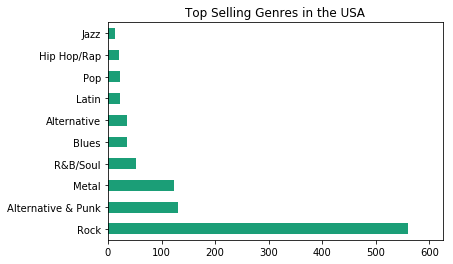

In [4]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    # colormap
    colormap=plt.cm.Dark2
)

plt.ylabel('')

# for i, label in enumerate(list(genre_sales_usa.index)):
#     score = genre_sales_usa.loc[label, "tracks_sold"]
#     label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
#             ).astype(int).astype(str) + "%"
#     plt.annotate(str(label), (score + 10, i - 0.15))

# plt.show()

- Rock Genre is most sold in USA
- followed by Punk, and Metal

In [5]:
# below is top sales support people
emplyoee_sales_performance_ = '''
WITH customer_support_rep_sales AS 
    (
    SELECT 
        i.customer_id,
        c.support_rep_id,
        SUM(i.total) total
    FROM invoice i
    INNER JOIN customer c ON c.customer_id = i.customer_id
    GROUP BY 1,2
    )
SELECT
    e.first_name || ' ' || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1;
'''

# without sales support
employee_sales_performance = '''
    
SELECT 
    e.first_name || ' ' || e.last_name employee,
    e.hire_date,
    SUM(i.total) total_sales
FROM invoice i
INNER JOIN customer c ON c.customer_id = i.customer_id
INNER JOIN employee e ON e.employee_id = c.support_rep_id
GROUP BY 1,2
    
'''


run_query(employee_sales_performance)


,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


## Plotting

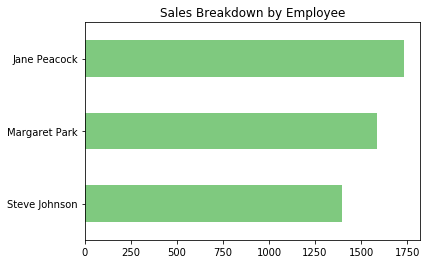

In [6]:
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index('employee', drop=True, inplace=True)
employee_sales.sort_values('total_sales', inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()

In [7]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
         CASE 
             WHEN (
                 SELECT COUNT(*)
                 FROM customer
                 WHERE country = c.country
                 ) = 1 THEN 'Other'
             ELSE c.country
          END AS country,
          c.customer_id,
          il.*
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id = il.invoice_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
    )
SELECT 
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
     SELECT
         country,
         count(distinct customer_id) customers,
         SUM(unit_price) total_sales,
         SUM(unit_price) / COUNT(distinct customer_id) customer_lifetime_value,
         SUM(unit_price) / COUNT(distinct invoice_id) average_order,
         CASE 
             WHEN country='Other' THEN 1
             ELSE 0
         END AS sort
     FROM country_or_other
     GROUP BY country
     ORDER BY sort ASC, total_sales DESC
    );
    '''
run_query(sales_by_country)
# need to dig in

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


## Visualizing Sales by Country

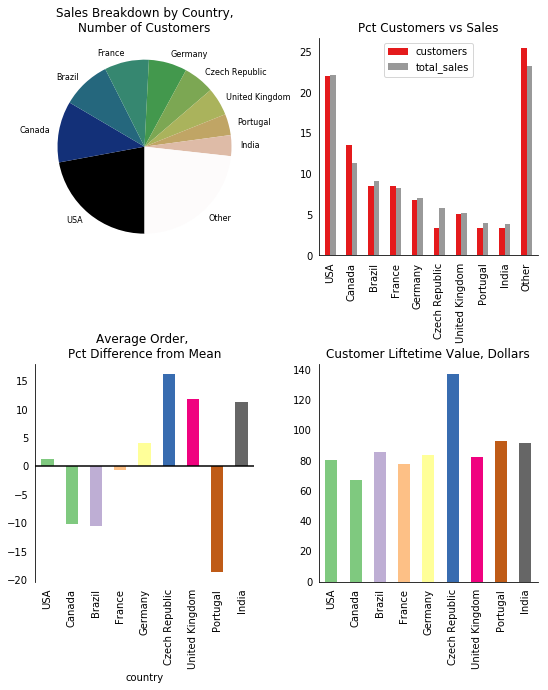

In [8]:
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
# color scheme 
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.gist_earth,
    fontsize=8
#     wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ['customers', 'total_sales']
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /=custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title='Pct Customers vs Sales'
)
ax2.tick_params(top=False, right=False, left=False, bottom=False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

#bottom left
avg_order = country_metrics['average_order'].copy()
country_metrics.index.name= ''
diff_from_avg = (avg_order * 100) / (sum(avg_order) /len(avg_order)) - 100
diff_from_avg.drop('Other', inplace=True)
diff_from_avg.plot.bar (
    ax=ax3,
    color=colors,
    title='Average Order, \nPct Difference from Mean'
)
ax3.tick_params(top=False,right=False, left=False, bottom=False)
ax3.axhline(0, color='k')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

#bottom right
ltv = country_metrics['customer_lifetime_value'].copy()
ltv.index.name=''
ltv.drop('Other', inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title='Customer Liftetime Value, Dollars'
)
ax4.tick_params(top=False, right=False, left=False, bottom=False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.show()

In [9]:
albums_vs_track = '''
WITH invoice_first_track AS
    (
     SELECT 
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) num_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                        SELECT COUNT(*) FROM invoice
                                        ) percent
FROM
    (
     SELECT
         ifs.*,
         CASE
             WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                       SELECT t2.album_id FROM track t2
                                       WHERE t2.track_id = ifs.first_track_id
                                      )
                   EXCEPT
                   
                   SELECT il2.track_id FROM invoice_line il2
                   WHERE il2.invoice_id = ifs.invoice_id
                  ) IS NULL
              AND
                  (
                   SELECT il2.track_id FROM invoice_line il2
                   WHERE il2.invoice_id = ifs.invoice_id
                   
                   EXCEPT
                   
                   SELECT t.track_id FROM track t
                   WHERE t.album_id = (
                                       SELECT t2.album_id FROM track t2
                                       WHERE t2.track_id = ifs.first_track_id
                                       )
                  ) IS NULL
              THEN 'yes'
              ELSE 'no'
        END AS 'album_purchase'
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''
run_query(albums_vs_track)


,album_purchase,num_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


based on the data, we would not purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue